In [61]:
from typing import Any, Dict, List, Union, Tuple

import pandas as pd
from pandas import DataFrame
from types import ModuleType

!pip install boto3
import boto3
import json
import re
import importlib
import sys
import os
import re
import ast

!pip install statsmodels
import statsmodels.api as sm

!pip install matplotlib
import matplotlib.pyplot as plt

In [62]:
CLUSTER_PATHS = {
    "BASE": "s3://asc-clickstream-emr-output/",
    "INPUT": "p2p_project_output/{provider}/{dataset}/"
    "behaviorDomain={behaviorDomain}/year={year}/month={month}/day={day}/*",
    "OUTPUT": "s3://asc-clickstream-emr-output/monitoring/p2p/dataset_version={dataset}/",
    "HISTORY": "s3://asc-clickstream-emr-output/monitoring/p2p_reg_history/dataset_version={dataset}/",
}

LOCAL_PATHS = {"INPUT": "C:\\Users\\malec\\PycharmProjects\\clickstream-monitoring\\resources\\p2p_data"}
PROVIDER = "Datos"
INTERM_DATA_TYPE = "agg"
MODES = ["local", "cluster"]
TOP_10_P2P_CLICKS_DATASETS = (
    "s3://asc-clickstream-emr-output/monitoring/resources/" "top_datasets/P2P_10_row_datasets.json"
)
TOP_10_P2P_PANELISTS_DATASETS = (
    "s3://asc-clickstream-emr-output/monitoring/resources/top_datasets/" "P2P_10_panelist_datasets.json"
)
TOP_5_P2P_CLICKS_DATASETS = (
    "s3://asc-clickstream-emr-output/monitoring/resources/top_datasets/" "P2P_5_row_datasets.json"
)
TOP_5_P2P_PANELISTS_DATASETS = (
    "s3://asc-clickstream-emr-output/monitoring/resources/top_datasets/" "P2P_5_panelist_datasets.json"
)
TOP_10_P2P_CLICKS_DOMAINS = (
    "s3://asc-clickstream-emr-output/monitoring/resources/top_domains/" "P2P_10_row_domains.json"
)
TOP_10_P2P_PANELISTS_DOMAINS = (
    "s3://asc-clickstream-emr-output/monitoring/resources/top_domains/" "P2P_10_panelist_domains.json"
)
TOP_5_P2P_CLICKS_DOMAINS = "s3://asc-clickstream-emr-output/monitoring/resources/top_domains/" "P2P_5_row_domains.json"
TOP_5_P2P_PANELISTS_DOMAINS = (
    "s3://asc-clickstream-emr-output/monitoring/resources/top_domains/" "P2P_5_panelist_domains.json"
)

BLACKLIST_DOMAINS = ["exacttarget"]
blacklist_domains: List[str] = BLACKLIST_DOMAINS

In [63]:
# 1. Load top Clicks and Panelists datasets
def load_json(path: str) -> Any:
    s3 = boto3.resource("s3")
    split_path = path.split("://")[1].split("/")
    bucket = split_path[0]
    key = "/".join(split_path[1:])
    content_object = s3.Object(bucket, key)
    file_content = content_object.get()["Body"].read().decode("utf-8")
    json_file = json.loads(file_content)
    return json_file

top_10_row_datasets = load_json(TOP_10_P2P_CLICKS_DATASETS)["datasets"]
top_10_panelist_datasets = load_json(TOP_10_P2P_PANELISTS_DATASETS)["datasets"]

top_5_row_datasets = load_json(TOP_5_P2P_CLICKS_DATASETS)["datasets"]
top_5_panelist_datasets = load_json(TOP_5_P2P_PANELISTS_DATASETS)["datasets"]

top_10_row_domains = load_json(TOP_10_P2P_CLICKS_DOMAINS)["domains"]
top_10_panelist_domains = load_json(TOP_10_P2P_PANELISTS_DOMAINS)["domains"]

top_5_row_domains = load_json(TOP_5_P2P_CLICKS_DOMAINS)["domains"]
top_5_panelist_domains = load_json(TOP_5_P2P_PANELISTS_DOMAINS)["domains"]

In [64]:
# 2. Loading historic data from monitoring in the form of JSONs; this data is used for training the model

# S3 bucket details
bucket_name = 'asc-clickstream-emr-output'
prefix = 'monitoring/p2p_reg_history/dataset_version=dataset576_V11/year=2024/'  # Optional: Specify a prefix for the path in the bucket

# Create an S3 client (No need to provide access key and secret key if credentials are available)
s3_client = boto3.client('s3')

# List objects in the bucket
objects = s3_client.list_objects(Bucket=bucket_name, Prefix=prefix)
#print(objects)

# Loop through each object and load JSON into Pandas DataFrame
columns = ['name', 'result', 'domain', 'dataset', 'behavior', 'metadatalink', 'pidSource', 'date', 'predicted', 'z_score', 'diff', 'percent_diff', 'threshold',
              'verdict']
dfs = []
for obj in objects.get('Contents', []):
    key = obj['Key']
    response = s3_client.get_object(Bucket=bucket_name, Key=key)
    content = response['Body'].read().decode('utf-8')
    actual_list = ast.literal_eval(content)
    #print(type(actual_list))
    dfs.extend(actual_list)

In [65]:
df = DataFrame(dfs)

In [66]:
df = df.sort_values(by=["date"]).reset_index(drop=True)

In [67]:
df = df[~df['domain'].isin(blacklist_domains)]

In [68]:
df

,name,result,domain,dataset,behavior,metadataLink,pidSource,date,predicted,z_score,diff,percent_diff,threshold,verdict,verdict_day,verdict_cur
0,count_rows_per_dataset,0.000000,All,dataset33,All,All,All,1704067200000,0.000000,0.000000,0.000000,0.000000,2,MISSING,NaN,NaN
1,count_rows_per_dataset,0.000000,All,dataset80,All,All,All,1704067200000,0.000000,0.000000,0.000000,0.000000,2,MISSING,NaN,NaN
2,count_rows_per_dataset,0.000000,All,dataset20,All,All,All,1704067200000,229.571429,6.666500,-229.571429,-1.000000,2,MISSING,NaN,NaN
3,count_rows_per_dataset,0.000000,All,dataset89,All,All,All,1704067200000,0.000000,0.000000,0.000000,0.000000,2,MISSING,NaN,NaN
4,count_rows_per_dataset,0.000000,All,dataset856,All,All,All,1704067200000,0.000000,0.000000,0.000000,0.000000,2,MISSING,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30677,count_unique_panelists_per_domain,1655.000000,costco,All,All,All,All,1709251200000,1570.080886,0.938092,84.919114,0.054086,2,OK,NaN,NaN
30678,count_unique_panelists_per_domain,461.000000,chewy,All,All,All,All,1709251200000,488.173185,0.844135,-27.173185,-0.055663,2,OK,NaN,NaN
30679,count_unique_panelists_per_domain,905.000000,bestbuy,All,All,All,All,1709251200000,989.884362,0.278078,-84.884362,-0.085752,2,OK,NaN,NaN
30680,count_unique_panelists_per_domain,505.000000,samsclub,All,All,All,All,1709251200000,470.697472,0.866048,34.302528,0.072876,2,OK,NaN,NaN


In [70]:
from datetime import datetime

# Milliseconds timestamp
milliseconds_timestamp = 1709251200000

# Convert milliseconds to seconds
seconds_timestamp = milliseconds_timestamp / 1000.0

# Convert to datetime object
datetime_object = datetime.utcfromtimestamp(seconds_timestamp)

print(datetime_object)

##############################################################

# Define the date
date_str = "2024-02-03"

# Convert the date string to a datetime object
date_obj = datetime.strptime(date_str, "%Y-%m-%d")

# Convert the datetime object to a timestamp (in seconds)
timestamp = datetime.timestamp(date_obj)

# Convert the timestamp to milliseconds
milliseconds = int(timestamp * 1000)

print(milliseconds)

2024-03-01 00:00:00
1706918400000


In [9]:
unique_values_name = df['name'].unique()
unique_values_name

array(['count_rows_per_domain', 'count_rows_per_dataset',
       'count_deterministic_pids_per_domain',
       'count_nondeterministic_pids_per_domain',
       'count_rows_per_metadatalink_per_domain',
       'count_rows_per_pidsource_per_domain',
       'count_behaviors_per_domain',
       'count_behaviors_with_extracted_pids_per_domain',
       'behavior_ratio_per_panelist_per_domain',
       'count_unique_panelists_per_domain',
       'count_unique_panelists_per_dataset',
       'count_unique_pids_per_domain'], dtype=object)

In [71]:
# Count rows
count_rows = df[df["name"] == "count_rows"]
count_rows_per_dataset = df[df["name"] == "count_rows_per_dataset"]
count_rows_per_domain = df[df["name"] == "count_rows_per_domain"]
count_rows_per_metadatalink_per_domain = df[df["name"] == "count_rows_per_metadatalink_per_domain"]
count_rows_per_pidsource_per_domain = df[df["name"] == "count_rows_per_pidsource_per_domain"]

# Count unique panelists
count_unique_panelists = df[df["name"] == "count_unique_panelists"]
count_unique_panelists_per_dataset = df[df["name"] == "count_unique_panelists_per_dataset"]
count_unique_panelists_per_domain = df[df["name"] == "count_unique_panelists_per_domain"]

# Count behaviors
count_behaviors_per_domain = df[df["name"] == "count_behaviors_per_domain"]

# Count behaviors with extracted pids
count_behaviors_with_extracted_pids_per_domain = df[df["name"] == "count_behaviors_with_extracted_pids_per_domain"]

# Behavior ratio per panelist
behavior_ratio_per_panelist_per_domain = df[df["name"] == "behavior_ratio_per_panelist_per_domain"]

# Count unique products IDs
count_unique_pids_per_domain = df[df["name"] == "count_unique_pids_per_domain"]

# Count deterministic product IDs
count_deterministic_pids_per_domain = df[df["name"] == "count_deterministic_pids_per_domain"]

# Count nondeterministic product IDS
count_nondeterministic_pids_per_domain = df[df["name"] == "count_nondeterministic_pids_per_domain"]

In [141]:
count_unique_panelists

,name,result,domain,dataset,behavior,metadataLink,pidSource,date,predicted,z_score,diff,percent_diff,threshold,verdict,verdict_day,verdict_cur


In [254]:
data = count_nondeterministic_pids_per_domain
training_set = data[data["date"] < 1706918400000]
testing_set = data[data["date"] >= 1706918400000]

In [255]:
training_set

,name,result,domain,dataset,behavior,metadataLink,pidSource,date,predicted,z_score,diff,percent_diff,threshold,verdict,verdict_day,verdict_cur
400,count_nondeterministic_pids_per_domain,97040.0,amazon,All,All,All,All,1704067200000,145978.793960,2.551608,-48938.793960,-0.335246,2,NOK,NaN,NaN
412,count_nondeterministic_pids_per_domain,2937.0,kroger,All,All,All,All,1704067200000,7617.839483,5.586647,-4680.839483,-0.614458,2,ERROR,NaN,NaN
413,count_nondeterministic_pids_per_domain,205.0,instacart,All,All,All,All,1704067200000,-175.000000,4.563824,380.000000,-2.171429,2,ERROR,NaN,NaN
414,count_nondeterministic_pids_per_domain,528.0,costco,All,All,All,All,1704067200000,569.005328,0.343498,-41.005328,-0.072065,2,OK,NaN,NaN
415,count_nondeterministic_pids_per_domain,256.0,chewy,All,All,All,All,1704067200000,452.478756,3.373751,-196.478756,-0.434228,2,NOK,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15138,count_nondeterministic_pids_per_domain,0.0,bestbuy,All,All,All,All,1706832000000,0.000000,0.000000,0.000000,0.000000,2,MISSING,NaN,NaN
15139,count_nondeterministic_pids_per_domain,0.0,sephora,All,All,All,All,1706832000000,0.000000,0.000000,0.000000,0.000000,2,MISSING,NaN,NaN
15140,count_nondeterministic_pids_per_domain,0.0,homedepot,All,All,All,All,1706832000000,0.000000,0.000000,0.000000,0.000000,2,MISSING,NaN,NaN
15141,count_nondeterministic_pids_per_domain,0.0,ulta,All,All,All,All,1706832000000,0.000000,0.000000,0.000000,0.000000,2,MISSING,NaN,NaN


In [256]:
data = training_set.copy()
data = data.sort_values(by=["date"]).reset_index(drop=True)
data["dow"] = data["date"].apply(lambda x: pd.to_datetime(x).weekday())
data["const"] = 1
data["trend"] = data.index + 1
data["is_monday"] = data["dow"].apply(lambda x: 1 if x == 0 else 0)
data["is_tuesday"] = data["dow"].apply(lambda x: 1 if x == 1 else 0)
data["is_wednesday"] = data["dow"].apply(lambda x: 1 if x == 2 else 0)
data["is_thursday"] = data["dow"].apply(lambda x: 1 if x == 3 else 0)
data["is_friday"] = data["dow"].apply(lambda x: 1 if x == 4 else 0)
data["is_saturday"] = data["dow"].apply(lambda x: 1 if x == 5 else 0)

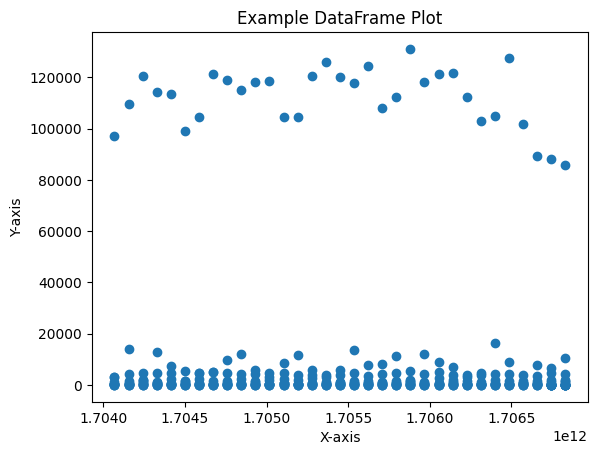

In [257]:
plt.scatter(training_set["date"], training_set["result"])
plt.title('Example DataFrame Plot')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

In [258]:
X = data[["const", "trend", "is_monday", "is_tuesday", "is_wednesday", "is_thursday", "is_friday", "is_saturday"]].astype("int")
y = data["result"].astype("float")

In [259]:
# HuberT Robust Linear Regression
rlm_model_huberT = sm.RLM(y, X, M=sm.robust.norms.HuberT())
rlm_results_huberT = rlm_model_huberT.fit()
rlm_results_huberT.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                 result   No. Observations:                  373
Model:                            RLM   Df Residuals:                      371
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Tue, 05 Mar 2024                                         
Time:                        23:27:11                                         
No. Iterations:                    27                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          691.6064     95.995      7.205      0.000     503.460     879.753
trend           -0.5886      0.890     -0.662      0.508      -2.332       1.155
is_monday             0          0        nan        nan           0           0
is_tuesday            0          0        nan        nan           0           0
is_wednesday          0          0        nan        nan           0           0
is_thursday    691.6064     95.995      7.205      0.000     503.460     879.753
is_friday             0          0        nan        nan           0           0
is_saturday           0          0        nan        nan           0           0
================================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

In [260]:
# Trimmed Mean Robust Linear Regression
rlm_model_trimmed_mean = sm.RLM(y, X, M=sm.robust.norms.TrimmedMean())
rlm_results_trimmed_mean = rlm_model_trimmed_mean.fit()
rlm_results_trimmed_mean.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                 result   No. Observations:                  373
Model:                            RLM   Df Residuals:                      371
Method:                          IRLS   Df Model:                            1
Norm:                     TrimmedMean                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Tue, 05 Mar 2024                                         
Time:                        23:27:13                                         
No. Iterations:                    10                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          185.3652     16.830     11.014      0.000     152.380     218.351
trend           -0.2985      0.156     -1.914      0.056      -0.604       0.007
is_monday             0          0        nan        nan           0           0
is_tuesday            0          0        nan        nan           0           0
is_wednesday          0          0        nan        nan           0           0
is_thursday    185.3652     16.830     11.014      0.000     152.380     218.351
is_friday             0          0        nan        nan           0           0
is_saturday           0          0        nan        nan           0           0
================================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

In [261]:
# Andrew Wave Robust Linear Regression
rlm_model_andrew_wave = sm.RLM(y, X, M=sm.robust.norms.AndrewWave())
rlm_results_andrew_wave = rlm_model_andrew_wave.fit()
rlm_results_andrew_wave.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                 result   No. Observations:                  373
Model:                            RLM   Df Residuals:                      371
Method:                          IRLS   Df Model:                            1
Norm:                      AndrewWave                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Tue, 05 Mar 2024                                         
Time:                        23:27:14                                         
No. Iterations:                    41                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          221.2145     25.924      8.533      0.000     170.404     272.025
trend           -0.1764      0.240     -0.734      0.463      -0.647       0.295
is_monday             0          0        nan        nan           0           0
is_tuesday            0          0        nan        nan           0           0
is_wednesday          0          0        nan        nan           0           0
is_thursday    221.2145     25.924      8.533      0.000     170.404     272.025
is_friday             0          0        nan        nan           0           0
is_saturday           0          0        nan        nan           0           0
================================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

In [262]:
# RamsayE Robust Linear Regression
rlm_model_ramsayE = sm.RLM(y, X, M=sm.robust.norms.RamsayE())
rlm_results_ramsayE = rlm_model_ramsayE.fit()
rlm_results_ramsayE.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                 result   No. Observations:                  373
Model:                            RLM   Df Residuals:                      371
Method:                          IRLS   Df Model:                            1
Norm:                         RamsayE                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Tue, 05 Mar 2024                                         
Time:                        23:27:17                                         
No. Iterations:                    42                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          412.6127     57.058      7.232      0.000     300.782     524.444
trend           -0.4070      0.529     -0.770      0.442      -1.444       0.630
is_monday             0          0        nan        nan           0           0
is_tuesday            0          0        nan        nan           0           0
is_wednesday          0          0        nan        nan           0           0
is_thursday    412.6127     57.058      7.232      0.000     300.782     524.444
is_friday             0          0        nan        nan           0           0
is_saturday           0          0        nan        nan           0           0
================================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

In [263]:
# Tukey Biweight Robust Linear Regression
rlm_model_tukey_biweight = sm.RLM(y, X, M=sm.robust.norms.TukeyBiweight())
rlm_results_tukey_biweight = rlm_model_tukey_biweight.fit()
rlm_results_tukey_biweight.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                 result   No. Observations:                  373
Model:                            RLM   Df Residuals:                      371
Method:                          IRLS   Df Model:                            1
Norm:                   TukeyBiweight                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Tue, 05 Mar 2024                                         
Time:                        23:27:18                                         
No. Iterations:                    41                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          222.3545     25.988      8.556      0.000     171.418     273.291
trend           -0.1786      0.241     -0.741      0.458      -0.651       0.294
is_monday             0          0        nan        nan           0           0
is_tuesday            0          0        nan        nan           0           0
is_wednesday          0          0        nan        nan           0           0
is_thursday    222.3545     25.988      8.556      0.000     171.418     273.291
is_friday             0          0        nan        nan           0           0
is_saturday           0          0        nan        nan           0           0
================================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

In [264]:
# Least Squares Robust Linear Regression
rlm_model_least_squares = sm.RLM(y, X, M=sm.robust.norms.LeastSquares())
rlm_results_least_squares = rlm_model_least_squares.fit()
rlm_results_least_squares.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                 result   No. Observations:                  373
Model:                            RLM   Df Residuals:                      371
Method:                          IRLS   Df Model:                            1
Norm:                    LeastSquares                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Tue, 05 Mar 2024                                         
Time:                        23:27:21                                         
No. Iterations:                     2                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         6272.9084   1644.843      3.814      0.000    3049.074    9496.742
trend           -6.6762     15.245     -0.438      0.661     -36.556      23.204
is_monday             0          0        nan        nan           0           0
is_tuesday            0          0        nan        nan           0           0
is_wednesday          0          0        nan        nan           0           0
is_thursday   6272.9084   1644.843      3.814      0.000    3049.074    9496.742
is_friday             0          0        nan        nan           0           0
is_saturday           0          0        nan        nan           0           0
================================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

In [265]:
# Robust Norm Hampel Linear Regression
rlm_model_hampel = sm.RLM(y, X, M=sm.robust.norms.Hampel())
rlm_results_hampel = rlm_model_hampel.fit()
rlm_results_hampel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                 result   No. Observations:                  373
Model:                            RLM   Df Residuals:                      371
Method:                          IRLS   Df Model:                            1
Norm:                          Hampel                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Tue, 05 Mar 2024                                         
Time:                        23:27:22                                         
No. Iterations:                    50                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          502.7918     71.077      7.074      0.000     363.484     642.100
trend           -0.5250      0.659     -0.797      0.425      -1.816       0.766
is_monday             0          0        nan        nan           0           0
is_tuesday            0          0        nan        nan           0           0
is_wednesday          0          0        nan        nan           0           0
is_thursday    502.7918     71.077      7.074      0.000     363.484     642.100
is_friday             0          0        nan        nan           0           0
is_saturday           0          0        nan        nan           0           0
================================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

In [266]:
if len(testing_set) < len(training_set):
    predicted_values_huberT = rlm_results_huberT.predict()[:len(testing_set)]
    predicted_values_trimmed_mean = rlm_results_trimmed_mean.predict()[:len(testing_set)]
    predicted_values_andrew_wave = rlm_results_andrew_wave.predict()[:len(testing_set)]
    predicted_values_ramsayE = rlm_results_ramsayE.predict()[:len(testing_set)]
    predicted_values_tukey_biweight = rlm_results_tukey_biweight.predict()[:len(testing_set)]
    predicted_values_least_squares = rlm_results_least_squares.predict()[:len(testing_set)]
    predicted_values_hampel = rlm_results_hampel.predict()[:len(testing_set)]
else:
    testing_set = testing_set[:len(training_set)]
    predicted_values_huberT = rlm_results_huberT.predict()[:len(testing_set)]
    predicted_values_trimmed_mean = rlm_results_trimmed_mean.predict()[:len(testing_set)]
    predicted_values_andrew_wave = rlm_results_andrew_wave.predict()[:len(testing_set)]
    predicted_values_ramsayE = rlm_results_ramsayE.predict()[:len(testing_set)]
    predicted_values_tukey_biweight = rlm_results_tukey_biweight.predict()[:len(testing_set)]
    predicted_values_least_squares = rlm_results_least_squares.predict()[:len(testing_set)]
    predicted_values_hampel = rlm_results_hampel.predict()[:len(testing_set)]

In [267]:
def mse_mae(testing_set, predicted_values):
    #predicted_values = predicted_values[:len(testing_set)]
    mae = 0
    mse = 0
    c = 0

    for i in range(len(testing_set)):
      mse += (testing_set.result.iloc[i] - predicted_values[i])**2
      mae += abs(testing_set.result.iloc[i] - predicted_values[i])
      c += 1

    return ["{:.4e}".format(mse / c), "{:.4e}".format(mae / c), "{:.4e}".format((mse/c)**(1/2))]

table = pd.DataFrame(columns=["MSE", "MAE", "RMSE"])
table.loc["HuberT"] = mse_mae(testing_set, predicted_values_huberT)
table.loc["Trimmed Mean"] = mse_mae(testing_set, predicted_values_trimmed_mean)
table.loc["Andrew Wave"] = mse_mae(testing_set, predicted_values_andrew_wave)
table.loc["RamsayE"] = mse_mae(testing_set, predicted_values_ramsayE)
table.loc["Tukey Biweight"] = mse_mae(testing_set, predicted_values_tukey_biweight)
table.loc["Least Squares"] = mse_mae(testing_set, predicted_values_least_squares)
table.loc["Hampel"] = mse_mae(testing_set, predicted_values_hampel)

table

,MSE,MAE,RMSE
HuberT,4.5893e+08,6.7454e+03,2.1423e+04
Trimmed Mean,4.6955e+08,6.3211e+03,2.1669e+04
Andrew Wave,4.6842e+08,6.3384e+03,2.1643e+04
RamsayE,4.6451e+08,6.4841e+03,2.1552e+04
Tukey Biweight,4.6840e+08,6.3388e+03,2.1642e+04
Least Squares,4.5845e+08,1.4468e+04,2.1412e+04
Hampel,4.6277e+08,6.5606e+03,2.1512e+04


In [268]:
count_nondeterministic_pids_per_domain_table = table

In [269]:
count_rows_per_dataset_table
count_rows_per_domain_table
count_rows_per_metadatalink_per_domain_table
count_rows_per_pidsource_per_domain_table
count_unique_panelists_per_dataset_table
count_unique_panelists_per_domain_table
count_behaviors_per_domain_table
count_behaviors_with_extracted_pids_per_domain_table
behavior_ratio_per_panelist_per_domain_table
count_unique_pids_per_domain_table
count_deterministic_pids_per_domain_table
count_nondeterministic_pids_per_domain_table

,MSE,MAE,RMSE
HuberT,4.5893e+08,6.7454e+03,2.1423e+04
Trimmed Mean,4.6955e+08,6.3211e+03,2.1669e+04
Andrew Wave,4.6842e+08,6.3384e+03,2.1643e+04
RamsayE,4.6451e+08,6.4841e+03,2.1552e+04
Tukey Biweight,4.6840e+08,6.3388e+03,2.1642e+04
Least Squares,4.5845e+08,1.4468e+04,2.1412e+04
Hampel,4.6277e+08,6.5606e+03,2.1512e+04


In [270]:
combined_table = pd.concat([count_rows_per_dataset_table, count_rows_per_domain_table,
                            count_rows_per_metadatalink_per_domain_table, count_rows_per_pidsource_per_domain_table,
                            count_unique_panelists_per_dataset_table, count_unique_panelists_per_domain_table,
                            count_behaviors_per_domain_table, count_behaviors_with_extracted_pids_per_domain_table,
                            behavior_ratio_per_panelist_per_domain_table, count_unique_pids_per_domain_table,
                            count_deterministic_pids_per_domain_table, count_nondeterministic_pids_per_domain_table])

averages = pd.DataFrame(columns=["MSE", "MAE", "RMSE"])
averages.loc["HuberT"] = combined_table.loc['HuberT', ['MSE', 'MAE', 'RMSE']].astype(float).mean()
averages.loc["Trimmed Mean"] = combined_table.loc['Trimmed Mean', ['MSE', 'MAE', 'RMSE']].astype(float).mean()
averages.loc["Andrew Wave"] = combined_table.loc['Andrew Wave', ['MSE', 'MAE', 'RMSE']].astype(float).mean()
averages.loc["RamsayE"] = combined_table.loc['RamsayE', ['MSE', 'MAE', 'RMSE']].astype(float).mean()
averages.loc["Tukey Biweight"] = combined_table.loc['Tukey Biweight', ['MSE', 'MAE', 'RMSE']].astype(float).mean()
averages.loc["Least Squares"] = combined_table.loc['Least Squares', ['MSE', 'MAE', 'RMSE']].astype(float).mean()
averages.loc["Hampel"] = combined_table.loc['Hampel', ['MSE', 'MAE', 'RMSE']].astype(float).mean()

sorted_table = averages.sort_values(by='MAE')
sorted_table

,MSE,MAE,RMSE
Trimmed Mean,4.342200e+09,14047.711025,49799.676117
Andrew Wave,4.323686e+09,14082.343908,49735.173542
Tukey Biweight,4.323625e+09,14082.518917,49734.756800
RamsayE,4.269245e+09,14432.044517,49248.038400
Hampel,4.257317e+09,14604.070525,49142.028933
HuberT,4.230591e+09,14863.153067,48993.688075
Least Squares,4.162006e+09,29326.815042,48551.984483


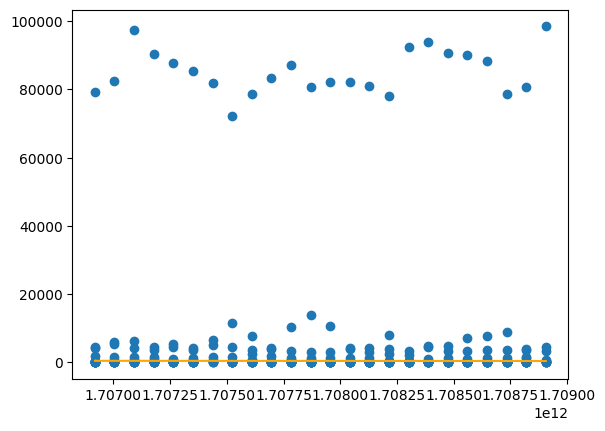

In [271]:
plt.scatter(testing_set["date"], testing_set["result"])
plt.plot(testing_set["date"], predicted_values_andrew_wave, color='orange')
plt.show()

In [272]:
data["predicted"] = rlm_results_andrew_wave.predict(X)
data["diff"] = data["result"] - data["predicted"]  # diff between predictions and reality
data["percent_diff"] = data["diff"] / (data["predicted"] + 1e-6)
data["threshold"] = 2
data["z_score"] = (abs(data["result"] - data["predicted"])) / data["diff"].std()
data["verdict"] = data.apply(lambda x: "OK" if (abs(x["z_score"]) < 2) else "NOK", axis=1)

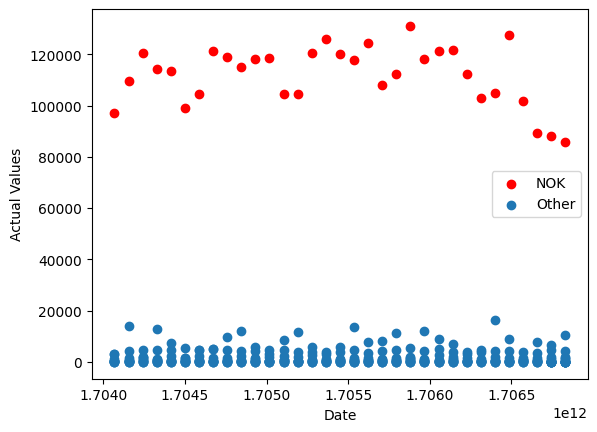

In [273]:
# Separate data based on verdict
nok_data = data[data["verdict"] == "NOK"]
other_data = data[data["verdict"] != "NOK"]

# Plot points for "NOK" verdicts with red color
plt.scatter(nok_data["date"], nok_data["result"], label='NOK', color='red')

# Plot points for other verdicts with default color
plt.scatter(other_data["date"], other_data["result"], label='Other')

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Actual Values')
plt.legend()

# Show plot
plt.show()

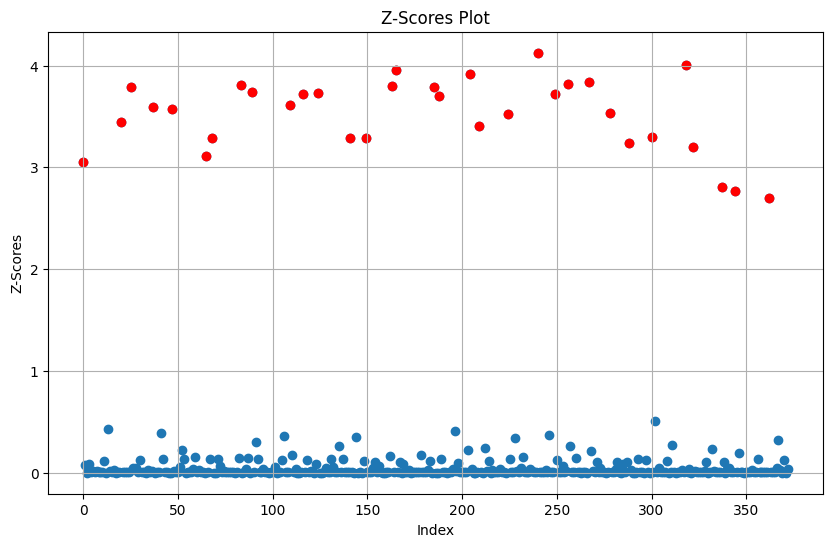

In [274]:
plt.figure(figsize=(10, 6))
plt.scatter(data.index, data["z_score"])
plt.scatter(nok_data.index, nok_data["z_score"], label='NOK', color='red')
plt.title('Z-Scores Plot')
plt.xlabel('Index')
plt.ylabel('Z-Scores')
plt.grid(True)
plt.show()